## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline
plt.style.use('ggplot')
sns.set()

from sklearn.preprocessing import StandardScaler,MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

Populating the interactive namespace from numpy and matplotlib


## Defining functions

In [2]:
def dsc_var(feat):   
    '''
    Get the info about the feature from the data dictionary
    '''
    mask = (dic_dados['DICIONÁRIO DE VARIÁVEIS - ENEM 2016'] == feat)
    index_start = dic_dados[mask].index.item()
    index_end  = index_start + 1
    while pd.isnull(dic_dados.iloc[index_end, 0]):
        index_end += 1 
    return dic_dados.iloc[index_start:index_end, :]


def get_info(df):
    '''
    Return a DataFrame with variable infos
    '''
    return pd.DataFrame({'Type': df.dtypes,
                       'Nunique': df.nunique(),
                       'NaN_percent': round(df.isna().sum()/len(df),3)*100,
                       'NaN': df.isna().sum()})
    
def pd_of_stats(df,col):
    '''
    Create a dataframe of descriptive Statistics
    '''
    stats = dict()
    stats['Mean']  = df[col].mean()
    stats['Std']   = df[col].std()
    stats['Var'] = df[col].var()
    stats['Kurtosis'] = df[col].kurtosis()
    stats['Skewness'] = df[col].skew()
    stats['CoefVar'] = stats['Std'] / stats['Mean']
    
    return pd.DataFrame(stats, index = col).T.round(2)


def pd_of_stats_quantile(df,col):
    '''
    Create a dataframe of quantile Statistics
    col is a list of features
    '''
    df_no_na = df[col].dropna()
    stats_q = dict()

    stats_q['Min'] = df[col].min()
    label = {0.25:"Q1", 0.5:'Median', 0.75:"Q3"}
    for percentile in np.array([0.25, 0.5, 0.75]):
        stats_q[label[percentile]] = df_no_na.quantile(percentile)
    stats_q['Max'] = df[col].max()
    stats_q['Range'] = stats_q['Max']-stats_q['Min']
    stats_q['IQR'] = stats_q['Q3']-stats_q['Q1']

    return pd.DataFrame(stats_q, index = col).T.round(2)

def cross_val_multiple_ml(estimator, X, y, cv):
    model = estimator.fit(X, y)
    y_pred = cross_val_predict(model, X, y, cv, n_jobs = -1)
    r2_cv = r2_score(y,y_pred)
    rmse_cv = mean_squared_error(y,y_pred, squared=False)
    print(f"R2: {r2_cv} and RMSE: {rmse_cv}" )
    return 

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

## Load data 

In [3]:
path = "~/Documents/Codenation_challenge/enem_treineiro/dados/" 
in_path = os.path.normcase(path + 'input/')
out_path = os.path.normcase(path+ 'output/')

In [4]:
dic_dados = pd.read_excel(path + 'Dicionario_Microdados_Enem_2016.xlsx')

In [5]:
df_enem_raw =  pd.read_csv(in_path +'train.csv')

In [6]:
df_enem_raw.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [7]:
df_enem_raw.shape

(13730, 167)

Get features available from the test dataset

In [8]:
df_enem_test = pd.read_csv(in_path + 'test.csv')

In [9]:
features = df_enem_test.columns.to_list()
feat_target = 'IN_TREINEIRO'

## append the target variable
features.append(feat_target)

print('Features to work with: \n', features)

Features to work with: 
 ['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'IN_TREINEIRO']


In [10]:
df_enem= df_enem_raw[features].copy()

In [11]:
df_enem.shape

(13730, 44)

In [12]:
pd.set_option('display.max_rows', df_enem_raw.shape[1]+1)

## Get the feature description here 

In [13]:
dsc_var('TP_ENSINO')

,DICIONÁRIO DE VARIÁVEIS - ENEM 2016,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
60,TP_ENSINO,Tipo de instituição que concluiu ou concluirá ...,1,Ensino Regular,1,Numérica
61,NaN,NaN,2,Educação Especial - Modalidade Substitutiva,NaN,NaN
62,NaN,NaN,3,Educação de Jovens e Adultos,NaN,NaN


## Raw Data info

In [14]:
df_info = get_info(df_enem)
print(df_info)

Type  Nunique  NaN_percent   NaN
NU_INSCRICAO             object    13730          0.0     0
CO_UF_RESIDENCIA          int64       27          0.0     0
SG_UF_RESIDENCIA         object       27          0.0     0
NU_IDADE                  int64       55          0.0     0
TP_SEXO                  object        2          0.0     0
TP_COR_RACA               int64        6          0.0     0
TP_NACIONALIDADE          int64        5          0.0     0
TP_ST_CONCLUSAO           int64        4          0.0     0
TP_ANO_CONCLUIU           int64       11          0.0     0
TP_ESCOLA                 int64        4          0.0     0
TP_ENSINO               float64        3         68.8  9448
TP_DEPENDENCIA_ADM_ESC  float64        4         68.8  9448
IN_BAIXA_VISAO            int64        2          0.0     0
IN_CEGUEIRA               int64        1          0.0     0
IN_SURDEZ                 int64        2          0.0     0
IN_DISLEXIA               int64        2          0.0     0
IN_DISC

In [15]:
numeric_feats = df_enem[features].select_dtypes(include = ['int', 'float']).columns.to_list()
numeric_feats

['TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO']

Let`s evaluate the target feature

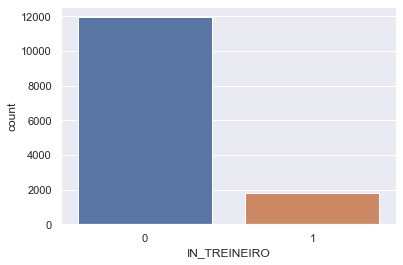

In [16]:
sns.countplot(df_enem[feat_target])
plt.show()

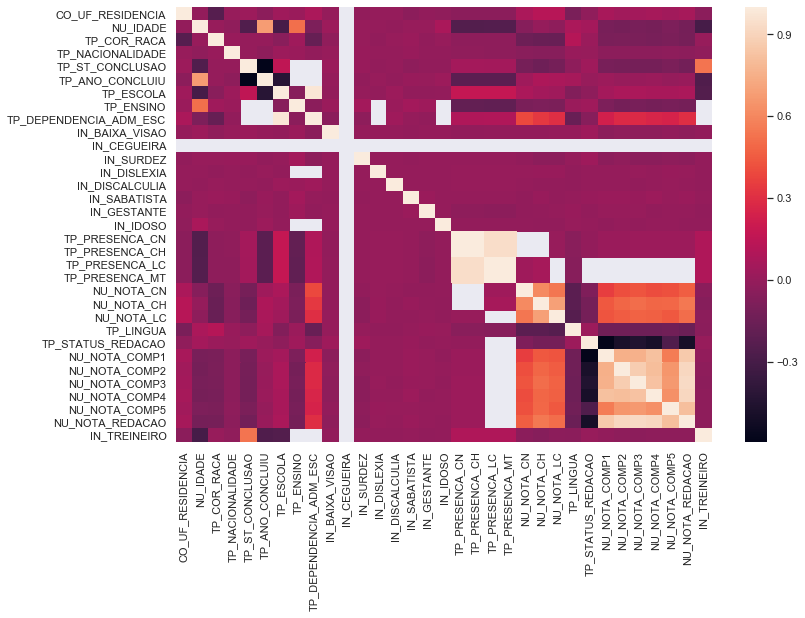

In [17]:
ax = plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_enem.corr())
b, t = plt.ylim() 
plt.ylim(b+0.5, t-0.5)
plt.show() 

In [18]:
#Notice how  "IN_TREINEIRO", the target variable, has no relation at all ("IN_TREINEIRO" == 0) for all  'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', "IN_CEGUEIRA". It has no explainability power over our decisions.
df_enem.loc[df_enem['TP_ENSINO']==1, feat_target].sum()

0

In [19]:
## TESTS CN and CH are applied on the same day
## TESTS LC and MT are applied on the same day

print(df_enem.filter(like = ('TP_PRESENCA')).sum(axis=0))

df_enem[['TP_PRESENCA_CN','TP_PRESENCA_LC','IN_TREINEIRO']].corr()

TP_PRESENCA_CN    10359
TP_PRESENCA_CH    10359
TP_PRESENCA_LC    10143
TP_PRESENCA_MT    10143
dtype: int64


,TP_PRESENCA_CN,TP_PRESENCA_LC,IN_TREINEIRO
TP_PRESENCA_CN,1.000000,0.943361,0.094692
TP_PRESENCA_LC,0.943361,1.000000,0.092454
IN_TREINEIRO,0.094692,0.092454,1.000000


In [20]:
states_mapping = dict(zip(df_enem['CO_UF_RESIDENCIA'],df_enem['SG_UF_RESIDENCIA']))
print(states_mapping)

{43: 'RS', 23: 'CE', 33: 'RJ', 13: 'AM', 29: 'BA', 51: 'MT', 26: 'PE', 31: 'MG', 21: 'MA', 24: 'RN', 50: 'MS', 41: 'PR', 15: 'PA', 53: 'DF', 52: 'GO', 32: 'ES', 35: 'SP', 42: 'SC', 22: 'PI', 17: 'TO', 16: 'AP', 25: 'PB', 11: 'RO', 28: 'SE', 27: 'AL', 12: 'AC', 14: 'RR'}


# Transforming data

Neste modelo decidimos não usar variáveis que tragam informações sobre o desempenho nas demais áreas. Estas normalmente são consideradas leakages variáveis, na prática não se disporia destas variáveis para prever a nota.   

In [21]:

#to_keep = [x for x in features if not in to_drop ]

In [22]:
df_enem = df_enem_raw[features].copy()

#drop ID data and SG_UF
df_enem.drop(['NU_INSCRICAO', 'SG_UF_RESIDENCIA'], axis =1, inplace = True)

#drop redação partial grades
df_enem.drop(columns = list(df_enem.filter(like = ('NU_NOTA_COMP')).columns), inplace = True)

# drop leakage data NOTAS keep only if the person was present or absent on the days of the tests
grades_features = list(df_enem.loc[:,'TP_PRESENCA_CN':'NU_NOTA_REDACAO'].columns)
grades_features.remove('TP_PRESENCA_LC')
grades_features.remove('TP_PRESENCA_CN')
df_enem.drop(columns = grades_features, inplace = True)

#drop variabe that have do explainability power
to_drop_unrelated =  ['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', "IN_CEGUEIRA"]
df_enem.drop(columns = to_drop_unrelated, inplace = True)

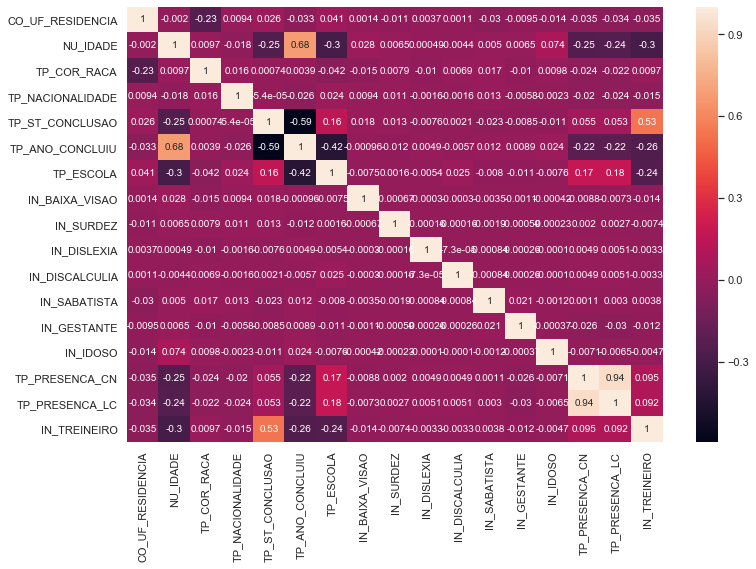

In [23]:
ax = plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_enem.corr(), annot = True)
b, t = plt.ylim() 
plt.ylim(b+0.5, t-0.5)
plt.show() 

In [24]:
print(df_enem.shape)

(13730, 26)


# Treat categories

In [25]:
list_CO = df_enem.filter(like = 'CO_').columns.to_list() # features that start with CO
list_IN = df_enem.filter(like = 'IN_').columns.to_list() # features that start with IN - bools
list_TP = df_enem.filter(like = 'TP_').columns.to_list() # features that start with TP
list_Q0 = df_enem.filter(like = 'Q0' ).columns.to_list() # features that start with Q00

list_categories = list_CO + list_IN + list_TP + list_Q0

for col in list_categories:
    df_enem[col] = df_enem[col].astype('category')

In [26]:
##Bool fetures
final_info = get_info(df_enem)
final_info[final_info['Nunique'] ==2 ].index.to_list()

['TP_SEXO',
 'IN_BAIXA_VISAO',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'Q025',
 'IN_TREINEIRO']

In [27]:
get_info(df_enem)

,Type,Nunique,NaN_percent,NaN
CO_UF_RESIDENCIA,category,27,0.0,0
NU_IDADE,int64,55,0.0,0
TP_SEXO,category,2,0.0,0
TP_COR_RACA,category,6,0.0,0
TP_NACIONALIDADE,category,5,0.0,0
TP_ST_CONCLUSAO,category,4,0.0,0
TP_ANO_CONCLUIU,category,11,0.0,0
TP_ESCOLA,category,4,0.0,0
IN_BAIXA_VISAO,category,2,0.0,0
IN_SURDEZ,category,2,0.0,0


In [28]:
#df_enem.drop(columns = ['Q027', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], inplace=True)

# Model

In [29]:
y = df_enem['IN_TREINEIRO']
X = df_enem.drop(columns=['IN_TREINEIRO'])

#transform
ordinal_features = list_Q0
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='most_frequent')),
    ('orde', OrdinalEncoder())])

categorical_features = list_TP
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ['NU_IDADE']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

#models
estimator_dict = dict()
estimator_dict['rf'] = RandomForestClassifier(n_jobs=-1,random_state=0)
estimator_dict['xgb'] = XGBClassifier(random_state=0)
estimator_dict['lr'] = LogisticRegression()

## Simple train-test-split

In [30]:
for model in estimator_dict.keys():

    reg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('estimator', estimator_dict[model])])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    reg.fit(X_train, y_train)
    
    score = reg.score(X_test, y_test)
    
    y_pred = reg.predict(X_test)
    print(f"Model {model} || Accuracy = {round(score,3)}")
    print(classification_report(y_test, y_pred))


Model rf || Accuracy = 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2411
           1       0.99      0.98      0.99       335

    accuracy                           1.00      2746
   macro avg       1.00      0.99      0.99      2746
weighted avg       1.00      1.00      1.00      2746

Model xgb || Accuracy = 0.995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2396
           1       0.99      0.97      0.98       350

    accuracy                           0.99      2746
   macro avg       0.99      0.98      0.99      2746
weighted avg       0.99      0.99      0.99      2746

Model lr || Accuracy = 0.975
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2421
           1       0.83      0.99      0.90       325

    accuracy                           0.97      2746
   macro avg       0.91      0.98      0

## Feature Selection

Model rf || k = 2 || Accuracy = 0.953
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2427
           1       0.71      1.00      0.83       319

    accuracy                           0.95      2746
   macro avg       0.86      0.97      0.90      2746
weighted avg       0.97      0.95      0.96      2746

Model rf || k = 4 || Accuracy = 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2380
           1       1.00      0.98      0.99       366

    accuracy                           1.00      2746
   macro avg       1.00      0.99      0.99      2746
weighted avg       1.00      1.00      1.00      2746

Model rf || k = 6 || Accuracy = 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2392
           1       1.00      0.98      0.99       354

    accuracy                           1.00      2746
   macro avg  

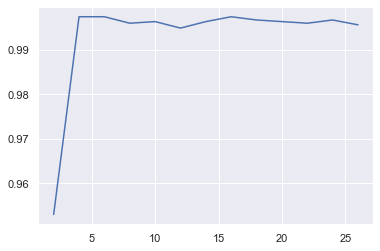

Model xgb || k = 2 || Accuracy = 0.966
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2398
           1       0.79      1.00      0.88       348

    accuracy                           0.97      2746
   macro avg       0.89      0.98      0.93      2746
weighted avg       0.97      0.97      0.97      2746

Model xgb || k = 4 || Accuracy = 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2385
           1       1.00      0.98      0.99       361

    accuracy                           1.00      2746
   macro avg       1.00      0.99      0.99      2746
weighted avg       1.00      1.00      1.00      2746

Model xgb || k = 6 || Accuracy = 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2390
           1       1.00      0.97      0.99       356

    accuracy                           1.00      2746
   macro av

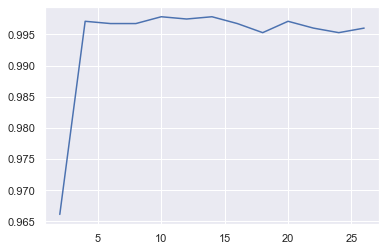

Model lr || k = 2 || Accuracy = 0.958
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      2383
           1       0.76      1.00      0.86       363

    accuracy                           0.96      2746
   macro avg       0.88      0.98      0.92      2746
weighted avg       0.97      0.96      0.96      2746

Model lr || k = 4 || Accuracy = 0.975
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2379
           1       0.84      1.00      0.92       367

    accuracy                           0.98      2746
   macro avg       0.92      0.99      0.95      2746
weighted avg       0.98      0.98      0.98      2746

Model lr || k = 6 || Accuracy = 0.971
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2400
           1       0.84      0.95      0.89       346

    accuracy                           0.97      2746
   macro avg  

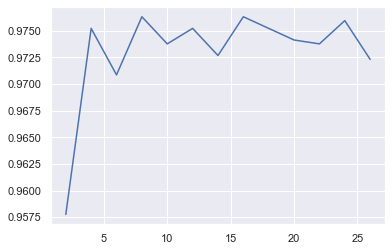

In [98]:
dic_mae = dict()

for model in estimator_dict.keys():

    k_vs_score = []
    end_size = df_enem.shape[1] + 1

    for k in range(2,end_size,2):
        
        reg = Pipeline(steps=[('preprocessor', preprocessor),
                              ('select', SelectKBest(score_func=f_classif, k=k)),
                              ('estimator', estimator_dict[model])])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        reg.fit(X_train, y_train)

        score = reg.score(X_test,y_test) 
        
        y_pred = reg.predict(X_test)
        
        
        print(f"Model {model} || k = {k} || Accuracy = {round(score,3)}")
        print(classification_report(y_test, y_pred))

        k_vs_score.append(score)
         
    
    dic_mae[model] = k_vs_score


    plt.plot(pd.Series(k_vs_score, index=range(2,end_size,2)))
    plt.show()
   

## Cross validation

In [100]:
estimator_dict = dict()
estimator_dict['rf'] = RandomForestClassifier(max_depth = 5, n_estimators = 500 ,random_state=0)
estimator_dict['xgb'] = XGBClassifier(max_depth = 3, n_estimators = 50, random_state=0)
estimator_dict['lr'] = LogisticRegression()


for model in estimator_dict.keys():

    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_selection', SelectKBest(k=4)),
                             ('estimator', estimator_dict[model])])

    scores = cross_val_score(reg, X, y, cv=5, scoring = 'accuracy' ) 
    print (estimator_dict[model])
    print (f'Cross-validated scores: {scores}')
    print (f"Accuracy of {model} with Cross Validation is: {scores.mean() * 100}" )
    print ('\n')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Cross-validated scores: [0.99635967 0.99708773 0.99599417 0.9989071  0.99672131]
Accuracy of rf with Cross Validation is: 99.70139971608259


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
      

## Grid Search

In [103]:
param_grid = {'feature_selection__k' : [4,8,10],
            'estimator': [RandomForestClassifier(n_jobs=-1,random_state=0),
                          XGBClassifier(random_state=0)],
            'estimator__max_depth': [3, 5 ],
            'estimator__n_estimators': [50, 100],
            }

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('feature_selection', SelectKBest(k=4)),
                      ('estimator', RandomForestClassifier())])

grid_search = GridSearchCV(reg, param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

print(f"Best score from grid search: {grid_search.score(X_test, y_test)}")
print(f"Best parameters : {grid_search.best_params_}")
print("\n")

Best score from grid search: 0.9970866715222141
Best parameters : {'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'estimator__max_depth': 3, 'estimator__n_estimators': 50, 'feature_selection__k': 4}




## Final model

    Vamos usar o modelo do Grid Search como modelo final!

```python
y_pred = grid_search.predict(X_test)
```

In [93]:
best_pipe = Pipeline([('preprocessor', preprocessor),
                      ('feature_selection', SelectKBest(k=4)),
                      ('estimator', RandomForestClassifier(max_depth=3,n_jobs=-1, n_estimators=50))])

best_pipe.fit(X_train, y_train)
best_pipe.predict(X_test)


#Get selected features
columns_preprocessed = get_column_names_from_ColumnTransformer(best_pipe.named_steps['preprocessor'])
print("Total features after preprocessing", len(columns_preprocessed))
print(columns_preprocessed)
features = best_pipe.named_steps['feature_selection']
print('\n Categorical Features transformed (x features)', list_TP)
print('\n Seleted Features',[x for i, x in enumerate(columns_preprocessed) if features.get_support()[i]])


Total features after preprocessing 47
['Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'x0_F', 'x0_M', 'x1_0', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x2_0', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x4_0', 'x4_1', 'x4_2', 'x4_3', 'x4_4', 'x4_5', 'x4_6', 'x4_7', 'x4_8', 'x4_9', 'x4_10', 'x5_1', 'x5_2', 'x5_3', 'x5_4', 'x6_0', 'x6_1', 'x6_2', 'x7_0', 'x7_1', 'x7_2', 'NU_IDADE']

 Categorical Features transformed (x features) ['TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_PRESENCA_CN', 'TP_PRESENCA_LC']

 Seleted Features ['x3_1', 'x3_3', 'x4_0', 'NU_IDADE']


In [89]:
print(dsc_var('TP_ST_CONCLUSAO')[['Unnamed: 2','Unnamed: 3']])

Unnamed: 2                                         Unnamed: 3
41          1                          Já concluí o Ensino Médio
42          2  Estou cursando e concluirei o Ensino Médio em ...
43          3  Estou cursando e concluirei o Ensino Médio apó...
44          4    Não concluí e não estou cursando o Ensino Médio


In [94]:
print(dsc_var('TP_ANO_CONCLUIU')[['Unnamed: 2','Unnamed: 3']])

Unnamed: 2       Unnamed: 3
45          0    Não informado
46          1             2015
47          2             2014
48          3             2013
49          4             2012
50          5             2011
51          6             2010
52          7             2009
53          8             2008
54          9             2007
55         10  Anterior a 2007


# Variáveis selecionadas

x3_1 = TP_ST_CONCLUSAO - 1 Já concluí o Ensino Médio 

x3_3 = TP_ST_CONCLUSAO - 3 Estou cursando e concluirei o Ensino Médio após 2016


x4_0 = TP_ANO_CONCLUIU - 0 Não informado

NU_IDADE

## TEST

In [105]:
answer = df_enem_test[['NU_INSCRICAO']].copy()
df_enem_test.head(3)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,...,NaN,NaN,E,F,G,B,B,A,NaN,D


In [107]:
X_test =  df_enem_test.copy()

#drop SG_UF
X_test.drop(['NU_INSCRICAO','SG_UF_RESIDENCIA'], axis =1, inplace = True)

#drop redação partial grades
X_test.drop(columns = list(X_test.filter(like = ('NU_NOTA_COMP')).columns), inplace = True)

# drop leakage data NOTAS keep only if the person was present or absent at the day of the math test
grades_features = list(X_test.loc[:,'TP_PRESENCA_CN':'NU_NOTA_REDACAO'].columns)
grades_features.remove('TP_PRESENCA_LC')
grades_features.remove('TP_PRESENCA_CN')
X_test.drop(columns = grades_features, inplace = True)

#drop variabe that have do explainability power
to_drop_unrelated =  ['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', "IN_CEGUEIRA"]
X_test.drop(columns = to_drop_unrelated, inplace = True)

list_CO = X_test.filter(like = 'CO_').columns.to_list() # features that start with CO
list_IN = X_test.filter(like = 'IN_').columns.to_list() # features that start with IN - bools
list_TP = X_test.filter(like = 'TP_').columns.to_list() # features that start with TP
list_Q0 = X_test.filter(like = 'Q0' ).columns.to_list() # features that start with Q00

list_categories = list_CO + list_IN + list_TP + list_Q0

for col in list_categories:
    X_test[col] = X_test[col].astype('category')

In [108]:
X_test.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_BAIXA_VISAO,IN_SURDEZ,...,TP_PRESENCA_CN,TP_PRESENCA_LC,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,19,F,1,1,1,3,1,0,0,...,1,0,E,E,H,B,B,C,D,A
1,15,24,M,3,2,1,4,1,0,0,...,0,0,B,C,B,A,A,C,D,A
2,29,16,F,2,1,3,0,1,0,0,...,1,0,E,F,G,B,B,A,NaN,D
3,41,17,F,1,1,2,0,2,0,0,...,1,1,E,E,E,C,B,B,C,A
4,53,19,F,1,1,1,1,1,0,0,...,1,1,E,E,E,B,B,B,D,A


In [109]:
#transform
ordinal_features = list_Q0
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='most_frequent')),
    ('orde', OrdinalEncoder())])

categorical_features = list_TP
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ['NU_IDADE']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

In [110]:
y_pred = grid_search.predict(X_test)
answer['IN_TREINEIRO'] = pd.Series(y_pred)

In [111]:
answer.head(20)

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
5,3f28749fb79fb059caf5aed79625a5addfd7a91a,0
6,bb2a0edddf3c59181a1496390aaaee7f32624d9d,1
7,cc7cab347fe5455aae983f3701ca40f84dc01949,0
8,95e9338f1da02f7bfa0e3194130afdccc0fb5457,1
9,155f84f2ee5b34e658f2adcc70f2ec83e37040cb,0


In [112]:
answer.to_csv(out_path+'answer.csv', index = False)